In [ ]:
# Step 1: Imports

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import networkx as nx

In [ ]:
# Step 2: Load and Clean Data

In [7]:
df = pd.read_csv("Tweets.csv")

In [55]:
df.shape

(27480, 5)

In [9]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [10]:
df.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [11]:
df.dropna(subset=['text','sentiment'], inplace = True)

In [16]:
texts = df['text'].values
texts

array([' I`d have responded, if I were going',
       ' Sooo SAD I will miss you here in San Diego!!!',
       'my boss is bullying me...', ...,
       ' Yay good for both of you. Enjoy the break - you probably need it after such hectic weekend  Take care hun xxxx',
       ' But it was worth it  ****.',
       '   All this flirting going on - The ATG smiles. Yay.  ((hugs))'],
      dtype=object)

In [17]:
sentiments = df['sentiment'].values
sentiments

array(['neutral', 'negative', 'negative', ..., 'positive', 'positive',
       'neutral'], dtype=object)

In [ ]:
# Step 3: Encode Labels

In [14]:
le = LabelEncoder()

labels = le.fit_transform(sentiments)
print(labels)

In [15]:
y= to_categorical(labels)

[1 0 0 ... 2 2 1]


In [19]:
# Step 4: Text Preprocessing

In [23]:
tokenizer = Tokenizer(num_words = 1000, oov_token='<OOV>')

tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)

x = pad_sequences(sequences, maxlen= 100)

In [24]:
# Step 5: Train/Test Split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [31]:
model = Sequential([
    Embedding(input_dim = 1000,output_dim=2, input_length=100),
    SimpleRNN(32),
    Dense(3, activation= 'softmax')
])

In [32]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.1)

Epoch 1/3
310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3905 - loss: 1.0897 - val_accuracy: 0.4206 - val_loss: 1.0715
Epoch 2/3
310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4550 - loss: 1.0410 - val_accuracy: 0.5871 - val_loss: 0.8943
Epoch 3/3
310/310 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6407 - loss: 0.8177 - val_accuracy: 0.5739 - val_loss: 0.9195


In [36]:
pred_probs = model.predict(x[:200])  # Limit to 200 for clarity in graph
pred_labels = np.argmax(pred_probs, axis=1)

pred_sentiments = le.inverse_transform(pred_labels)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [45]:
# Sample 10 tweets
sample_tweets = df['text'].values[:10]
sample_sequences = x[:10]


In [49]:
preds = np.argmax(model.predict(sample_sequences), axis=1)
pred_sentiments = le.inverse_transform(preds)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [50]:
# Step 8: Build Network Graph

Epoch 1/3


D:\Users\shrey\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.4269 - loss: 1.0608 - val_accuracy: 0.5633 - val_loss: 0.8582
Epoch 2/3
344/344 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7100 - loss: 0.7093 - val_accuracy: 0.6579 - val_loss: 0.7741
Epoch 3/3
344/344 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8625 - loss: 0.4031 - val_accuracy: 0.6377 - val_loss: 0.8988
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


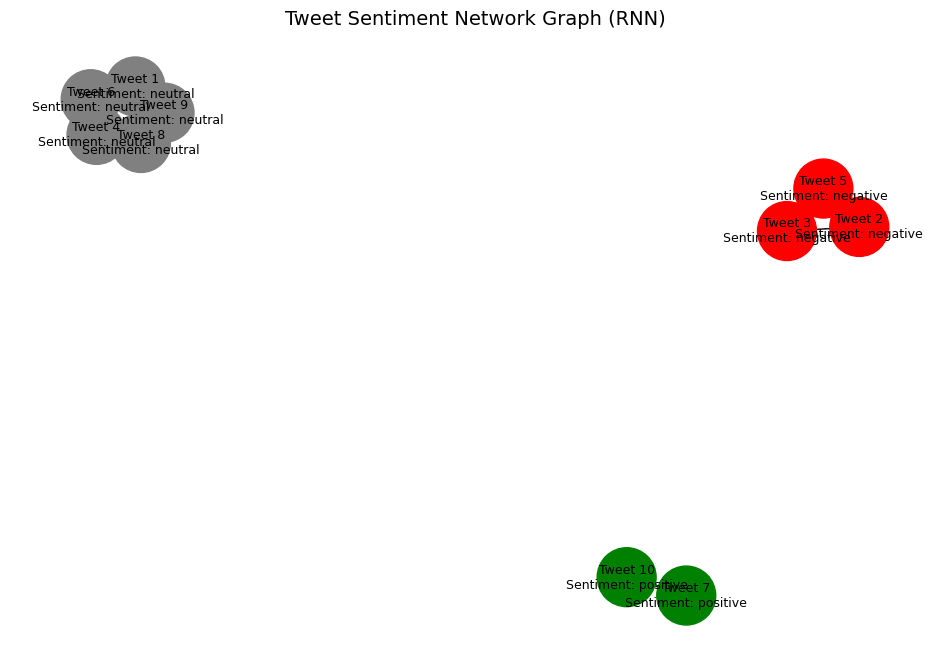

In [54]:


# Sample 10 tweets
sample_tweets = df['text'].values[:10]
sample_sequences = X[:10]

# Predict sentiments
preds = np.argmax(model.predict(sample_sequences), axis=1)
pred_sentiments = le.inverse_transform(preds)

# Build Network Graph
G = nx.Graph()

# Add nodes with sentiment
for i, text in enumerate(sample_tweets):
    label = f"Tweet {i+1}\nSentiment: {pred_sentiments[i]}"
    G.add_node(i, label=label, sentiment=pred_sentiments[i])

# Connect nodes with same predicted sentiment
for i in range(len(preds)):
    for j in range(i+1, len(preds)):
        if preds[i] == preds[j]:
            G.add_edge(i, j)

# Visualize graph
pos = nx.spring_layout(G, seed=42)
colors = ['green' if G.nodes[n]['sentiment'] == 'positive'
          else 'red' if G.nodes[n]['sentiment'] == 'negative'
          else 'gray' for n in G.nodes()]
labels = nx.get_node_attributes(G, 'label')

# plt.figure(figsize=(12, 8))
# nx.draw(G, pos, with_labels=True, labels=labels,
#         node_color=colors, node_size=1800, font_size=9)
# plt.title("Tweet Sentiment Network Graph (RNN)", fontsize=14)
# plt.axis('off')
# plt.show()

fig, ax = plt.subplots(figsize=(12, 8))
nx.draw(G, pos, ax=ax, with_labels=True, labels=labels,
        node_color=colors, node_size=1800, font_size=9)
plt.title("Tweet Sentiment Network Graph (RNN)", fontsize=14)
plt.axis('off')
plt.show()